In [79]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [80]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

Run below only of not downloaded dataset

DATASET 1: MAESTRO

In [91]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

DATASET 2: GAME MUSIC

In [349]:
data_dir = pathlib.Path('data/game')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'game',
      origin='https://drive.google.com/file/d/14e0MCJD7RH_m7CpsFZWPIpO0WgQrwi64/view',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

DATASET 3: BACH

In [230]:
data_dir = pathlib.Path('data/bach/bach')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'bach',
      origin='http://www.bachcentral.com/download.html',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [350]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1284


take a sample file

In [351]:
sample_file = filenames[0]
print(sample_file)

data\game\1\1 _Raid and Pacific Attack_ Title Screen Song.mid


generating pretty midi object

In [352]:
pm = pretty_midi.PrettyMIDI(sample_file)

test a sample file - export the midi

In [353]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [354]:
display_audio(pm)

retrieve instrument

In [355]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 3
Instrument name: Synth Brass 1


MAKE NOTE SEQUENCE

In [356]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=55, note_name=G3, duration=0.8409
1: pitch=52, note_name=E3, duration=0.4318
2: pitch=48, note_name=C3, duration=1.7273
3: pitch=53, note_name=F3, duration=0.8636
4: pitch=55, note_name=G3, duration=0.8409
5: pitch=60, note_name=C4, duration=0.4091
6: pitch=65, note_name=F4, duration=0.4318
7: pitch=67, note_name=G4, duration=0.4318
8: pitch=64, note_name=E4, duration=0.4091
9: pitch=65, note_name=F4, duration=0.2045


there a 3 variables to represent a note: pitch, step AKA when it starts and duration

midi -> note sequence converter

In [357]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [358]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,55,0.522727,1.363636,0.000000,0.840909
1,52,1.386364,1.818182,0.863636,0.431818
2,48,1.818182,3.545454,0.431818,1.727273
3,53,3.568182,4.431818,1.750000,0.863636
4,55,4.454545,5.295454,0.886364,0.840909


show compact note list

In [359]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G3', 'E3', 'C3', 'F3', 'G3', 'C4', 'F4', 'G4', 'E4', 'F4'],
      dtype='<U3')

plot first couple notes

In [360]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

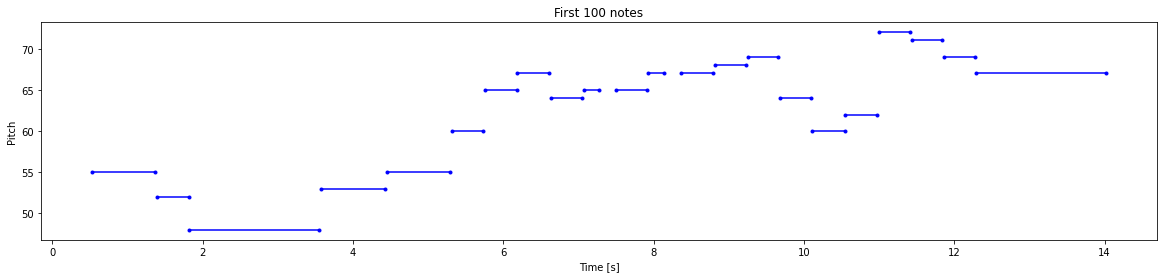

In [361]:
plot_piano_roll(raw_notes, count=100)

plot the entire track.

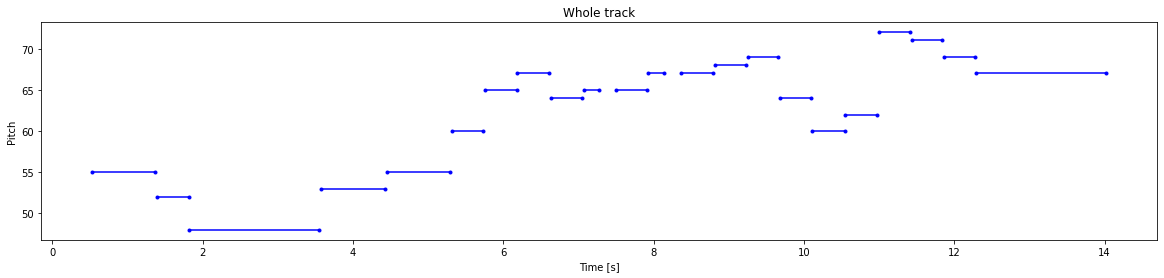

In [362]:
plot_piano_roll(raw_notes)

value distribution

In [363]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

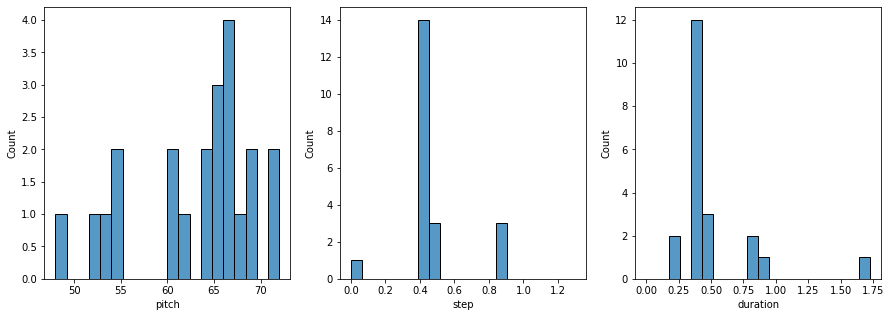

In [364]:
plot_distributions(raw_notes)

create midi file from note sequence -> test note sequence to MIDI

In [365]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [366]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [133]:
display_audio(example_pm)

creating training dataset

extract notes from a wished amount of midi files

In [372]:
num_files = 50
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [373]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 12386


creating a tf.data.Dataset from the note sequence

In [374]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [375]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

training model in batches, each batch contains notes as features and proceeding notes as labels
using window function with seq_lengh for creating those

In [376]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

setting seq_lenth ( or using [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner).) vocab_size is standard for pretty_midi

In [390]:
seq_length = 20
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(20, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

shape is (100, 1): model takes in first 100 then predicts next note

In [391]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (20, 3)
sequence elements (first 10): tf.Tensor(
[[0.4296875  0.         0.84090902]
 [0.40625    0.86363629 0.43181815]
 [0.375      0.43181815 1.72727258]
 [0.4140625  1.74999985 0.86363629]
 [0.4296875  0.88636356 0.84090902]
 [0.46875    0.86363629 0.40909088]
 [0.5078125  0.43181815 0.43181815]
 [0.5234375  0.43181815 0.43181815]
 [0.5        0.45454542 0.40909088]
 [0.5078125  0.43181815 0.20454544]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=69.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.4318181458333328>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.4090908750000004>}


batching examples, configuring dataset

In [392]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [393]:
train_ds.element_spec

(TensorSpec(shape=(64, 20, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

model has three outputs, one for each note variable. pitch and duration use a custom loss function based on mean squared error for non-negative values

In [394]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [395]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 20, 3)]      0           []                               
                                                                                                  
 lstm_10 (LSTM)                 (None, 128)          67584       ['input_11[0][0]']               
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_10[0][0]']                
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_10[0][0]']                
                                                                                           

testing the model.evaluate function

In [396]:
losses = model.evaluate(train_ds, return_dict=True)
losses

193/193 [==============================] - 4s 10ms/step - loss: 7.1331 - duration_loss: 0.7924 - pitch_loss: 4.8440 - step_loss: 1.4967


{'loss': 7.133056163787842,
 'duration_loss': 0.7923857569694519,
 'pitch_loss': 4.843964099884033,
 'step_loss': 1.4967083930969238}

balancing using the loss_weights argument to compile

In [397]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

loss becomes the weighted sum of individual losses

In [398]:
model.evaluate(train_ds, return_dict=True)

193/193 [==============================] - 3s 11ms/step - loss: 2.5313 - duration_loss: 0.7924 - pitch_loss: 4.8440 - step_loss: 1.4967


{'loss': 2.5312914848327637,
 'duration_loss': 0.7923857569694519,
 'pitch_loss': 4.843964099884033,
 'step_loss': 1.4967083930969238}

training model

In [399]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

choosing number of epochs

In [400]:
%%time
epochs = 100

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100
193/193 [==============================] - 6s 21ms/step - loss: 1.0917 - duration_loss: 0.0587 - pitch_loss: 4.1612 - step_loss: 0.8250
Epoch 2/100
193/193 [==============================] - 4s 22ms/step - loss: 1.0265 - duration_loss: 0.0468 - pitch_loss: 3.8087 - step_loss: 0.7893
Epoch 3/100
193/193 [==============================] - 4s 22ms/step - loss: 0.9964 - duration_loss: 0.0442 - pitch_loss: 3.4406 - step_loss: 0.7801 3s - loss: 0.2582 - duration_loss: 0.0472 - pitch_loss: 3.57 - ETA: 0s - loss: 1.0267 - duration_loss: 0.0439 - pitch_loss: 3.4441 - step_
Epoch 4/100
193/193 [==============================] - 4s 22ms/step - loss: 0.9855 - duration_loss: 0.0423 - pitch_loss: 3.3488 - step_loss: 0.7757 1s - loss: 0.7877 - duration_los
Epoch 5/100
193/193 [==============================] - 4s 22ms/step - loss: 0.9781 - duration_loss: 0.0414 - pitch_loss: 3.3173 - step_loss: 0.7708 2s - loss:
Epoch 6/100
193/193 [==============================] - 4s 22ms/step - loss: 0

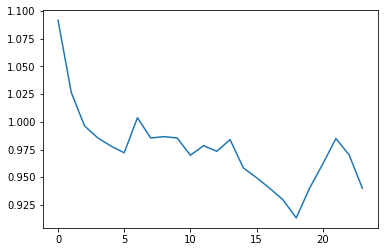

In [401]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes. 

For note pitch, it draws a sample from softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

temperature controls randomness

In [402]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 1

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

changing temperature and the starting sequence in next_notes

In [403]:
temperature = 1.5
num_predictions = 200

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [188]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,58,0.330586,0.529356,0.330586,0.859942
1,72,1.252773,0.524809,1.583359,2.108168
2,75,1.149436,0.791066,2.732795,3.523861
3,75,1.396942,0.743747,4.129737,4.873483
4,77,1.340692,0.786613,5.470428,6.257041
5,77,1.373011,0.768537,6.843440,7.611977
6,72,1.338045,0.805335,8.181484,8.986820
7,75,1.338965,0.805953,9.520449,10.326402
8,75,1.370807,0.773623,10.891256,11.664879
9,75,1.369396,0.765370,12.260652,13.026022


In [405]:
out_file = 'output10.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

visualising generated notes

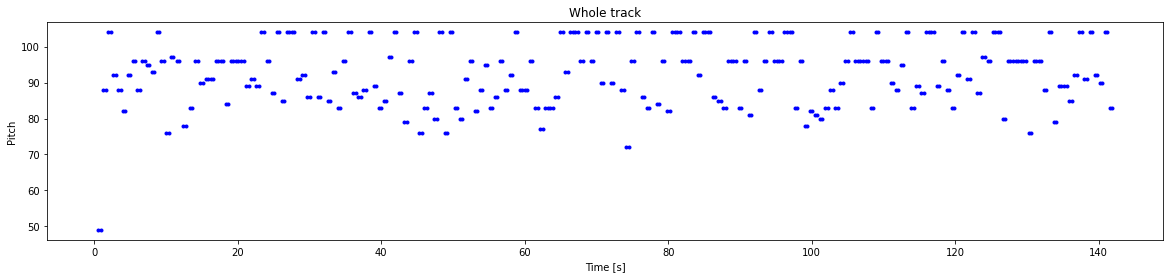

In [404]:
plot_piano_roll(generated_notes)

distributions

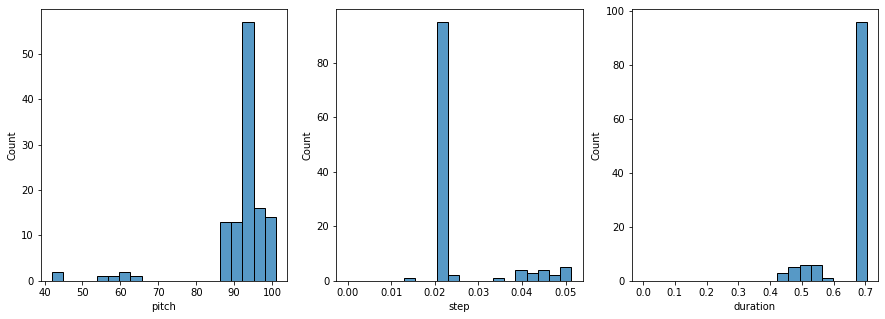

In [ ]:
plot_distributions(generated_notes)